<a href="https://colab.research.google.com/github/ekgren/workshop/blob/main/Day1/Workshop_Primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST, Maskininlärningens "Hello World!"

I första lab-delen av workshoppen ska vi gå igenom ett exempel med bildigenkänning: MNIST.

MNIST är ett dataset bestående av små bilder (28 x 28 pixlar) av siffror (0-9), med tillhörande sifferetikett (alltså siffran bilden föreställer). 

Datan består av 60.000 träningsexempel och 10.000 testexempel.

Vi börjar med att importera pythonpaket som kommer användas.

torch och torchvision är maskininlärningsbibliotek. 

*torch* är grundpaketet. Detta innehåller matematiska funnktioner, GPU-funktionalitet, ramverk för att definiera modeller, optimiera dessa m.m. och i synnerhet autograd: Ramverket som används för att beräkna gradienter.

*torchvision* är ett tillägg till torch för just bildhantering.

*matplotlib* är ett bibliotek för att visa diagram och bilder.

*tqdm* är ett bibliotek som visar "progress bars".

itertools är ett internt pythonbibliotek med hjälpfunktioner för iteratorer.


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import tqdm
import itertools

Vi börjar med att ladda ner datan, och tranfsormera den till pytorch-tensorer. 
Datan består av 60.000 träningsexempel och 10.000 testexempel med svartvita bilder och etiketter.

In [2]:
transform = torchvision.transforms.Compose(
    [
     torchvision.transforms.ToTensor(),
     ]
)

mnist_train = torchvision.datasets.MNIST(
    '/files', 
    train=True,
    download=True,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    '/files', 
    train=False,
    download=True,
    transform=transform
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Datan är i form av *tensorer*: Alltså strukturerade flyttal. Nedan visualiserar vi hur det första träningsexemplet ser ut som en tensor (alltså en matris av 28 x 28 reella tal), i bildform, och vilken etikett bilden datapunkten.

tensorform:
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.07 0.07 0.07 0.49 0.53 0.69 0.10 0.65 1.00 0.97 0.50 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.12 0.14 0.37 0.60 0.67 0.99 0.99 0.99 0.99 0.99 0.88 0.67 0.99 0.95 0.76 0.25 0.00 0.00 0.00 0.00
0.00 0.0

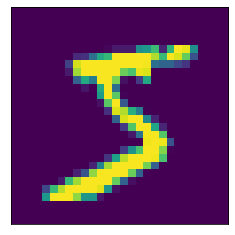

Etikett: 5


In [3]:
fig, ax = plt.subplots()

print('tensorform:')
for row in mnist_train[0][0][0]:
  print(' '.join(['{:.2f}'.format(val) for val in row]))

print('bildform:')
ax.imshow(mnist_train[0][0][0])
ax.set_yticks([])
ax.set_xticks([])

plt.show()

print('Etikett: {}'.format(mnist_train[0][1]))

Vi pröver med en enkel modell:

$y_d = b_d + \sum_{ij} pixel_{ij} \theta_{dij}$

Denna modell associerar varje pixel i bilden med en poäng per siffra, och summerar sedan ihop alla pixlars poänger. 

Vi implementerar modellen som en pytorch-modul. Pytorch-moduler förenklar 
koden genom att modulen ansvarar för parametrarna.

In [23]:
torch.randn(28, 28).div(28).norm() 

tensor(1.0237)

In [24]:
class Simple(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.theta = torch.nn.Parameter(torch.randn(10, 28, 28) / 28)
    self.b = torch.nn.Parameter(torch.zeros(10))

  def forward(self, image):
    """
    Funktion som givet en bild ger en sannolikhetsdistribution över siffror.

    Varje enskild pixel associeras med varje siffra, för att få fram sifferpoängen 
    för en bild, multipliceras pixelvärden med motsvarande pixel-siffervärden och
    summeras sedan ihop.

    alltså för en bild:

    score[i] = b[i] = sum(image[h, w] * w[i, h, w] for h, w in [(0,0)..(28,28)])

    image: en "batch" bilder med form (B x 1 x 28 x 28)
    ger: en "batch" med sifferpoäng med form (B x 10)
    """

    pixel_digit_score = image * self.theta
    digit_score = self.b + pixel_digit_score.sum((2,3))
    return digit_score


In [25]:
BATCH_SIZE=32
EPOCHS = 5
DEVICE = 'cuda'

train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Utvärdering

Nedan definieras utvärderingsförfarandet.

Funktionen tar en modell, går igenom all data i mnist-utvärderingsdatan, och returnerar den genomsnittliga lossen samt träffsäkerheten.

In [26]:
@torch.no_grad()
def eval_model(model):
  N = len(mnist_test)

  # Skapa en tqdm-progress bar
  batches = tqdm.tqdm(test_dataloader)

  # Initialiser statistik
  hits = torch.zeros(()).to(DEVICE)
  loss = torch.zeros(()).to(DEVICE)
  for image, label in batches:
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    # Beräkna sifferpoängen enligt modellen
    scores = model(image)

    #Uppdatera loss och hits
    loss += torch.nn.functional.cross_entropy(scores, label, reduction='sum')
    hits += (scores.argmax(1) == label).sum()

  # Normalisera loss och hits så att vi får genomsnittlig loss och accuracy
  loss = (loss / N).item()
  acc = (hits / N).item()


  return loss, acc

# Träning

Nedan definieras ett träningsförfarande för en epok. 

Funktionen tar en modell och en optimerare, och går igenom all data i mnist-träningsdatan, och uppdaterar modellen enligt optimeraren. 

In [27]:

def train_epoch(model, optimizer):
  batches = tqdm.tqdm(train_dataloader)

  for ix, (image, label) in enumerate(batches):
    image = image.to(DEVICE)
    label = label.to(DEVICE)

    # Nollställ parametrarnas gradienter
    optimizer.zero_grad()

    # Beräkna sifferpoängen för bilderna.
    scores = model(image)

    # Givet Sifferpoängen och den riktiga siffran beräknas en loss.
    loss = torch.nn.functional.cross_entropy(scores, label)
    
    # Beräkna gradienten av lossen med avseende på modellens parametrar.
    loss.backward()

    # Uppdatera parametrarna
    optimizer.step()

    if ix % 10 == 0:
      batches.set_description('loss {:.2f}'.format(loss.item()))

# Träningsloop
Nedan är en träningsloop. 
Vi börjar med att initialisera en ny modell, och flytta den till GPUn.

Därefter skapar vi en optimerare, som ansvarar för att uppdatera modellens parametrar baserat på deras gradienter.

Loopen går ut på att gå igenom all data EPOCH gånger, och per epok träna modellen på alla träningsdata (*train_epoch*), samt utvärdera den på utvärderingsdatan (*eval_model*).

In [28]:

#Initialisera en ny modell (och lägg den på GPUn)
model = Simple().to(device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(EPOCHS):
  # Utvärdera modellen
  print('loss {:.2f}, accuracy: {:.1%}'.format(*eval_model(model)))

  # Träna modellen på all träningsdata
  train_epoch(model, optimizer)

#Utvärdera modellen
print('loss {:.2f}, accuracy: {:.1%}'.format(*eval_model(model)))



100%|██████████| 313/313 [00:01<00:00, 177.85it/s]


loss 2.39, accuracy: 5.7%


100%|██████████| 313/313 [00:01<00:00, 181.76it/s]


loss 0.47, accuracy: 88.4%


100%|██████████| 313/313 [00:01<00:00, 177.83it/s]


loss 0.40, accuracy: 89.6%


loss 0.61:  35%|███▌      | 665/1875 [00:04<00:08, 144.93it/s]


KeyboardInterrupt: ignored

In [12]:
class Simple2(torch.nn.Module):
  """
  Denna modell är identisk med Simple
  """
  def __init__(self):
    super().__init__()
    self.l1 = torch.nn.Linear(28*28, 10, bias=True)

  def forward(self, image):
    (B, C, W, H) = image.shape
    assert C == 1
    assert W == H == 28
    return self.l1(image.reshape(B, W*H))


class Deep(torch.nn.Module):
  """
  """
  def __init__(self, *hidden_dims):
    super().__init__()
    sizes = [28*28, *hidden_dims]

    inout = zip(sizes, sizes[1:])

    layers = []

    for indim, outdim in zip(sizes, sizes[1:]):
      layers.append(torch.nn.Linear(indim, outdim))
      layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(outdim, 10))
    
    self.f = torch.nn.Sequential(*layers)
  
  def forward(self, image):
    (B, C, W, H) = image.shape
    assert C == 1
    assert W == H == 28
    return self.f(image.reshape(B, W*H))


In [13]:


model.f

Sequential(
  (0): Linear(in_features=784, out_features=42, bias=True)
  (1): ReLU()
  (2): Linear(in_features=42, out_features=23, bias=True)
  (3): ReLU()
  (4): Linear(in_features=23, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=10, bias=True)
)

In [15]:

#Initialisera en ny modell (och lägg den på GPUn)
#model = Deep(42, 23, 12).to(device=DEVICE)
model = Simple2().to(device=DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(EPOCHS):
  # Utvärdera modellen
  print('loss {:.2f}, accuracy: {:.1%}'.format(*eval_model(model)))

  # Träna modellen på all träningsdata
  train_epoch(model, optimizer)

#Utvärdera modellen
print('loss {:.2f}, accuracy: {:.1%}'.format(*eval_model(model)))



100%|██████████| 313/313 [00:01<00:00, 176.59it/s]


loss 2.36, accuracy: 5.1%


100%|██████████| 313/313 [00:01<00:00, 176.57it/s]


loss 0.48, accuracy: 88.3%


loss 0.54:  37%|███▋      | 702/1875 [00:04<00:07, 148.69it/s]


KeyboardInterrupt: ignored